# Validation methods for time seies

## How to do it

### 1. Import the libraries and authenticate.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import nasdaqdatalink
import seaborn as sns
import matplotlib.pyplot as plt

nasdaqdatalink.ApiConfig.api_key = 'hbwVh8xyxkjEKo8D1P8c'

### 2. Download the monthly US unemployment rate from years 2010-2019.

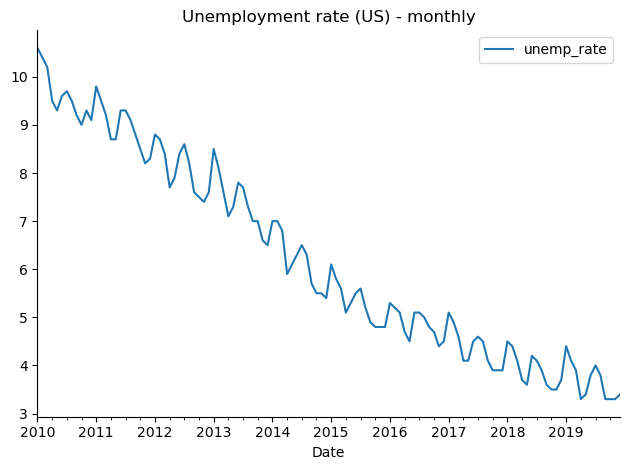

In [5]:
df = (
    nasdaqdatalink.get(dataset='FRED/UNRATENSA',
                       start_date='2010-01-01',
                       end_date='2019-12-31')
    .rename(columns={'Value': 'unemp_rate'})
)
df.plot(title="Unemployment rate (US) - monthly")

plt.tight_layout()
sns.despine()


### 3. Create simple features.

In [6]:
df['linear_trend'] = range(len(df))
df['month'] = df.index.month
df

,unemp_rate,linear_trend,month
Date,,,
2010-01-01,10.6,0,1
2010-02-01,10.4,1,2
2010-03-01,10.2,2,3
2010-04-01,9.5,3,4
2010-05-01,9.3,4,5
...,...,...,...
2019-08-01,3.8,115,8
2019-09-01,3.3,116,9
2019-10-01,3.3,117,10


### 4. Use one-hot encoding for the month feature.

In [7]:
month_dummies = pd.get_dummies(
    df['month'], drop_first=True, prefix='month'
)

df = df.join(month_dummies).drop(columns=['month'])
df

,unemp_rate,linear_trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Date,,,,,,,,,,,,,
2010-01-01,10.6,0,0,0,0,0,0,0,0,0,0,0,0
2010-02-01,10.4,1,1,0,0,0,0,0,0,0,0,0,0
2010-03-01,10.2,2,0,1,0,0,0,0,0,0,0,0,0
2010-04-01,9.5,3,0,0,1,0,0,0,0,0,0,0,0
2010-05-01,9.3,4,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,3.8,115,0,0,0,0,0,0,1,0,0,0,0
2019-09-01,3.3,116,0,0,0,0,0,0,0,1,0,0,0
2019-10-01,3.3,117,0,0,0,0,0,0,0,0,1,0,0


### 5. Separate the target from the features.

In [8]:
X = df.copy()
y = X.pop('unemp_rate')

### 6. Define the expanding window walk-forward validation and print the indices of the folds.

In [9]:
expanding_cv = TimeSeriesSplit(n_splits=5, test_size=12)

for fold, (train_ind, valid_ind) in enumerate(expanding_cv.split(X)):
    print(f"Fold: {fold} ---")
    print(f"Train indices: {train_ind}")
    print(f"Valid indices: {valid_ind}")
    print()

Fold: 0 ---
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Valid indices: [60 61 62 63 64 65 66 67 68 69 70 71]

Fold: 1 ---
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Valid indices: [72 73 74 75 76 77 78 79 80 81 82 83]

Fold: 2 ---
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
Valid indices: [84 85 86 87 88 89 90 91 92 93 94 95]

Fold: 3 ---
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22

### 7. Evaluate the model’s performance using the expanding window validation.

In [11]:
scores = []
for train_ind, valid_ind in expanding_cv.split(X):
    lr = LinearRegression()
    lr.fit(X.iloc[train_ind], y.iloc[train_ind])
    y_pred = lr.predict(X.iloc[valid_ind])
    scores.append(
        mean_absolute_percentage_error(y.iloc[valid_ind], y_pred)
    )

print(f"Scores: {scores}")
print(f"AVG. score: {np.mean(scores)}")

Scores: [0.03705079312389442, 0.07828415627306348, 0.11981060282172962, 0.16829494012910826, 0.2546045965163436]
AVG. score: 0.13160901777282788


In [14]:
cv_scores = cross_validate(
    LinearRegression(),
    X, y,
    cv=expanding_cv,
    scoring=["neg_mean_absolute_percentage_error",
             "neg_root_mean_squared_error"]
)

pd.DataFrame(cv_scores)

,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error
0,0.001946,0.000975,-0.037051,-0.232500
1,0.001406,0.000908,-0.078284,-0.433547
2,0.001439,0.000735,-0.119811,-0.520073
3,0.001714,0.000749,-0.168295,-0.662540
4,0.001270,0.000761,-0.254605,-0.928998


### 8. Define the sliding window validation and print the indices of the folds.

In [15]:
sliding_cv = TimeSeriesSplit(n_splits=5, test_size=12, max_train_size=60)

for fold, (train_ind, valid_ind) in enumerate(sliding_cv.split(X)):
    print(f"Fold: {fold} ---")
    print(f"Train indices: {train_ind}")
    print(f"Valid indices: {valid_ind}")
    print()

Fold: 0 ---
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Valid indices: [60 61 62 63 64 65 66 67 68 69 70 71]

Fold: 1 ---
Train indices: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71]
Valid indices: [72 73 74 75 76 77 78 79 80 81 82 83]

Fold: 2 ---
Train indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
Valid indices: [84 85 86 87 88 89 90 91 92 93 94 95]

Fold: 3 ---
Train indices: [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92 93 9

### 9. Evaluate the model’s performance using the sliding window validation.

In [16]:
cv_scores = cross_validate(
    LinearRegression(),
    X, y,
    cv=sliding_cv,
    scoring=["neg_mean_absolute_percentage_error",
             "neg_root_mean_squared_error"]
)

pd.DataFrame(cv_scores)

,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error
0,0.001665,0.000866,-0.037051,-0.232500
1,0.001432,0.000765,-0.097125,-0.524333
2,0.001172,0.000716,-0.126609,-0.550749
3,0.001129,0.000719,-0.129454,-0.518194
4,0.001097,0.000635,-0.108759,-0.407428


In [17]:
-1 * cv_scores['test_neg_mean_absolute_percentage_error'].mean()

0.09979962624891425

# Feature engineering for time series

## How to do it

### 1. Import the libraries

In [18]:
import numpy as np
import pandas as pd
from datetime import date

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklego.preprocessing import RepeatingBasisFunction


In [21]:
# temporary change for this recipe
import seaborn as sns
sns.set_palette(["grey", "blue"])

### 2. Generate a time series with repeating patterns.

<Axes: title={'center': 'Generated time series'}>

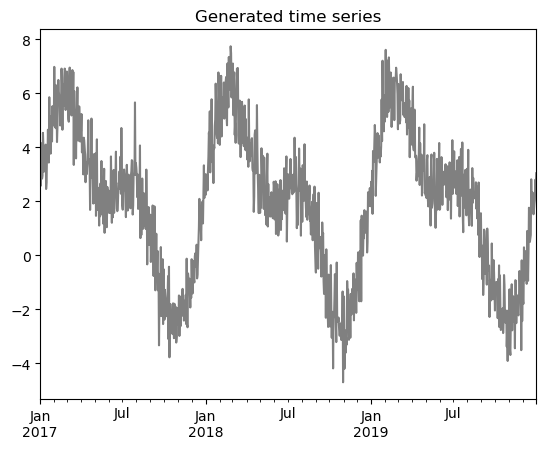

In [22]:
np.random.seed(42)
range_of_dates = pd.date_range(start='2017-01-01', end='2019-12-31')
X = pd.DataFrame(index=range_of_dates)
X['day_nr'] = range(len(X))
X['day_of_year'] = X.index.day_of_year
signal_1 = 2 + 3 * np.sin(X['day_nr'] / 365 * 2 * np.pi)
signal_2 = 2 * np.sin(X['day_nr'] / 365 * 4 * np.pi + 365/2)
noise = np.random.normal(0, 0.81, len(X))
y = signal_1 + signal_2 + noise
y.name = 'y'
y.plot(title="Generated time series")

In [23]:
X

,day_nr,day_of_year
2017-01-01,0,1
2017-01-02,1,2
2017-01-03,2,3
2017-01-04,3,4
2017-01-05,4,5
...,...,...
2019-12-27,1090,361
2019-12-28,1091,362
2019-12-29,1092,363
2019-12-30,1093,364


### 3. Store the time series in a new DataFrame

In [28]:
results_df = y.to_frame()
results_df.columns = ['y_true']
results_df.head()

,y_true
2017-01-01,2.969692
2017-01-02,2.572678
2017-01-03,3.325853
2017-01-04,4.150575
2017-01-05,2.842004


### 4. Encode the month information as dummies

In [29]:
X_1 = pd.get_dummies(
    X.index.month, drop_first=True, prefix='month'
)
X_1.index = X.index
X_1

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2017-01-01,0,0,0,0,0,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0
2017-01-03,0,0,0,0,0,0,0,0,0,0,0
2017-01-04,0,0,0,0,0,0,0,0,0,0,0
2017-01-05,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0,0,0,0,0,0,0,0,0,0,1
2019-12-28,0,0,0,0,0,0,0,0,0,0,1
2019-12-29,0,0,0,0,0,0,0,0,0,0,1
2019-12-30,0,0,0,0,0,0,0,0,0,0,1


### 5. Fit a linear regression model and plot the in-sample prediction.

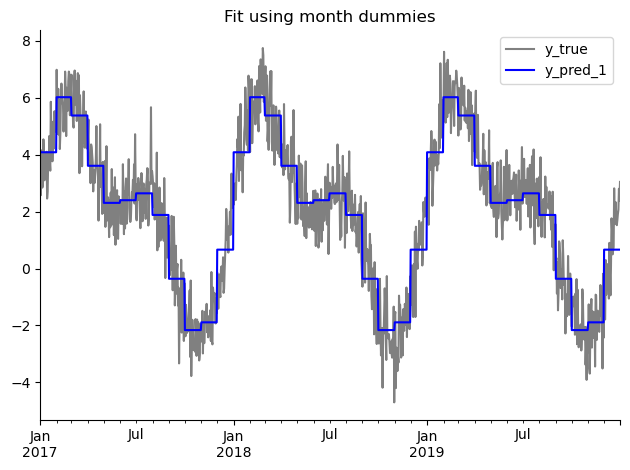

In [30]:
model_1 = LinearRegression().fit(X_1, y)

results_df['y_pred_1'] = model_1.predict(X_1)
(
    results_df[['y_true', 'y_pred_1']]
    .plot(title="Fit using month dummies")
)

plt.tight_layout()
sns.despine()

### 6. Define functions used for creating the cyclical encoding.

In [31]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

### 7. Encode the month and day information using cyclical encoding.

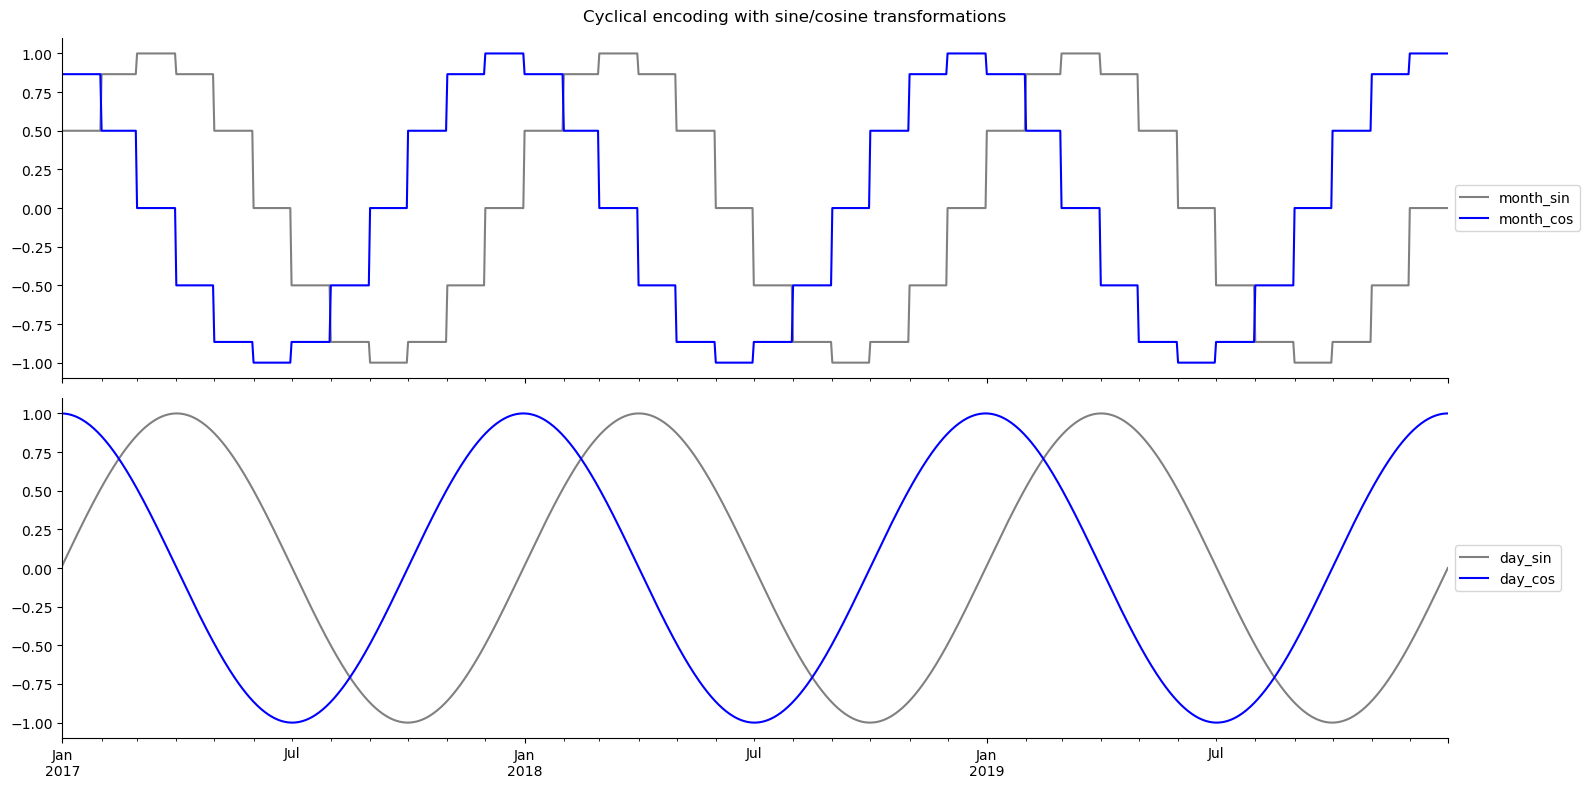

In [33]:
X_2 = X.copy()
X_2['month'] = X_2.index.month

X_2['month_sin'] = sin_transformer(12).fit_transform(X_2)['month']
X_2['month_cos'] = cos_transformer(12).fit_transform(X_2)['month']

X_2['day_sin'] = (
    sin_transformer(365).fit_transform(X_2)['day_of_year']
    )
X_2['day_cos'] = (
    cos_transformer(365).fit_transform(X_2)['day_of_year']
    )

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
X_2[['month_sin', 'month_cos']].plot(ax=ax[0])
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
X_2[['day_sin', 'day_cos']].plot(ax=ax[1])
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.suptitle("Cyclical encoding with sine/cosine transformations")

plt.tight_layout()
sns.despine()

<Axes: title={'center': 'Cyclical encoding using sine/cosine transformations'}, xlabel='month_sin', ylabel='month_cos'>

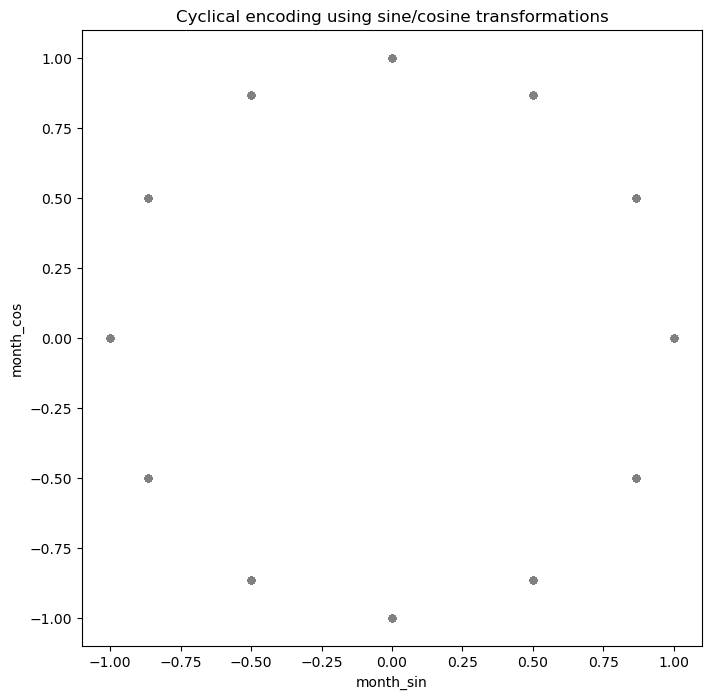

In [34]:
(
    X_2[X_2.index.year == 2017]
    .plot(
        kind='scatter',
        x='month_sin',
        y='month_cos',
        figsize=(8, 8),
        title="Cyclical encoding using sine/cosine transformations"
    )
)

### 8. Fit a model using the daily sine/cosine features.

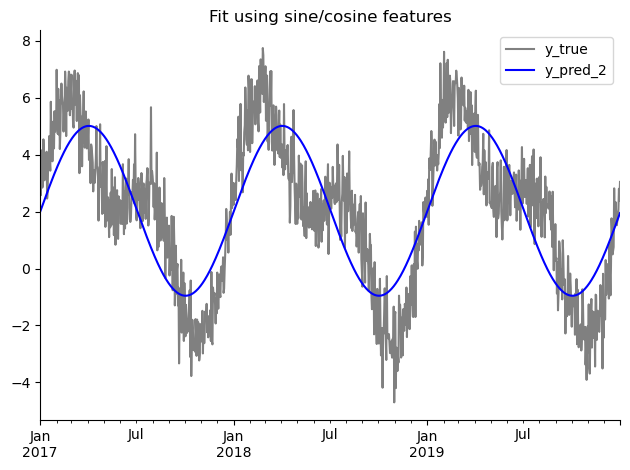

In [37]:
X_2 = X_2[['day_sin', 'day_cos']]

model_2 = LinearRegression().fit(X_2, y)

results_df['y_pred_2'] = model_2.predict(X_2)
(
    results_df[['y_true', 'y_pred_2']]
    .plot(title='Fit using sine/cosine features')
)

plt.tight_layout()
sns.despine()

### 9. Create features using the radial basis functions.

In [38]:
rbf = RepeatingBasisFunction(
    n_periods=12,
    column='day_of_year',
    input_range=(1, 365),
    remainder='drop'
)
rbf.fit(X)
X_3 = pd.DataFrame(index=X.index,
                   data=rbf.transform(X))

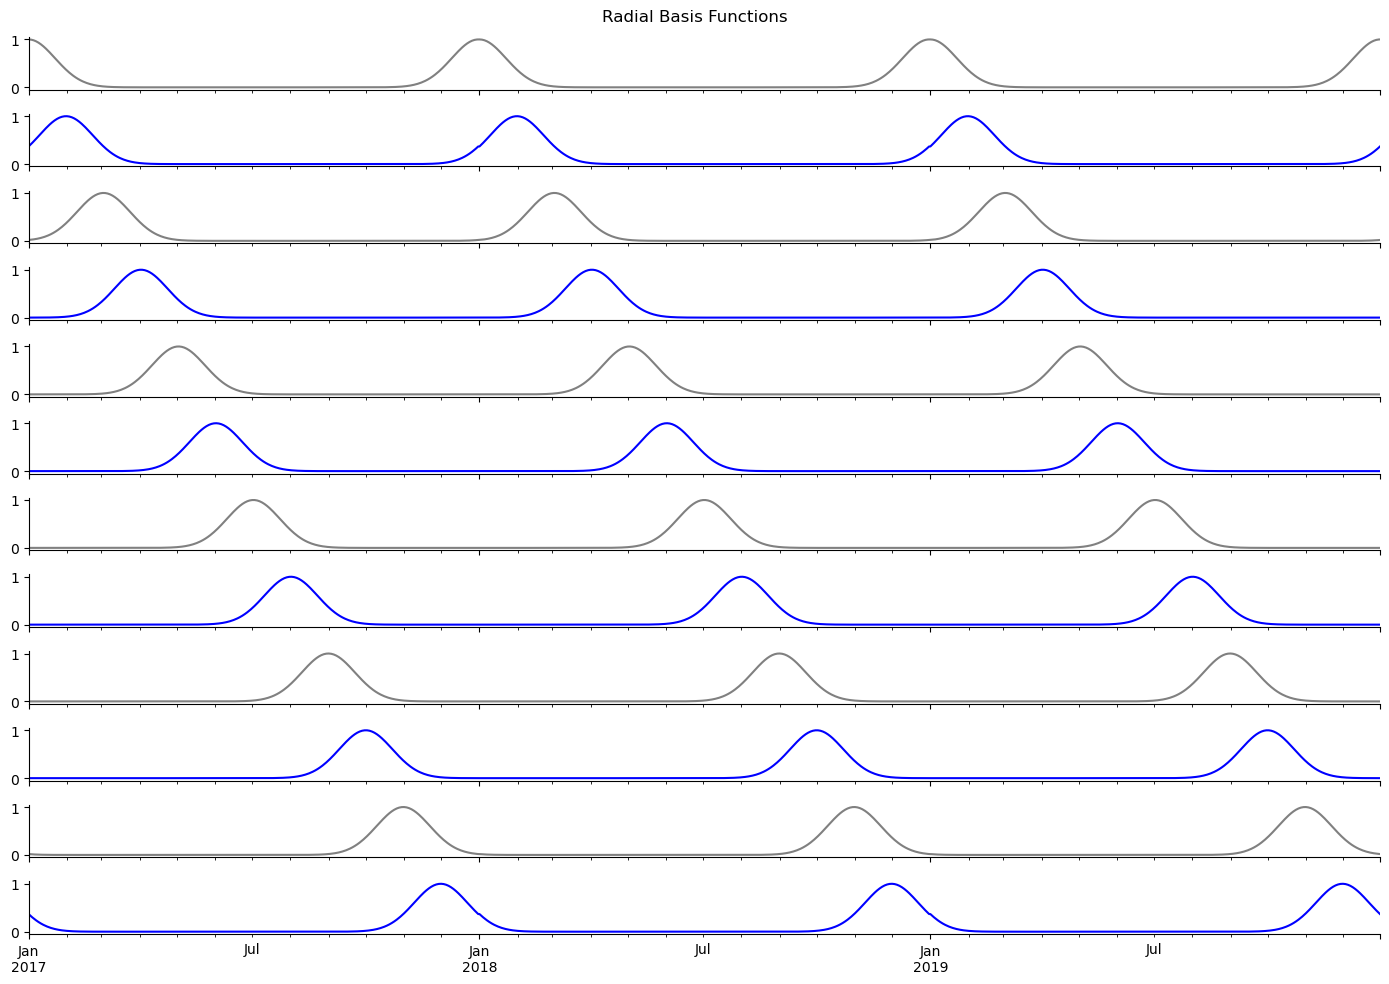

In [39]:
X_3.plot(subplots=True, 
         sharex=True,
         title='Radial Basis Functions',
         legend=False, figsize=(14, 10))

plt.tight_layout()
sns.despine()

### 10. Fit a model using the RBF features.

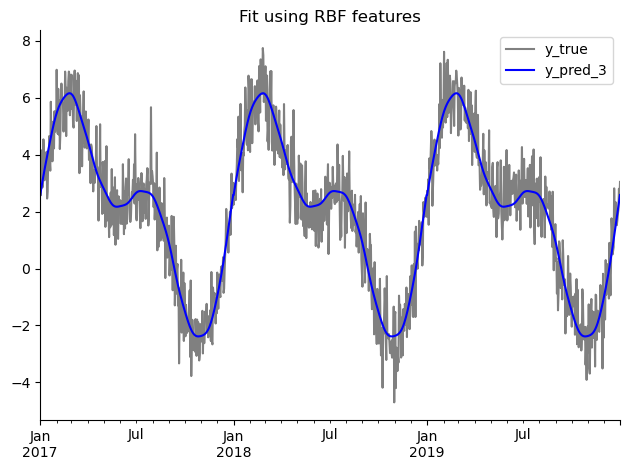

In [40]:
model_3 = LinearRegression().fit(X_3, y)

results_df['y_pred_3'] = model_3.predict(X_3)
(
    results_df[['y_true', 'y_pred_3']]
    .plot(title='Fit using RBF features')
)

plt.tight_layout()
sns.despine()

## There's more

### 1. Import the libraries

In [43]:
from sktime.transformations.series.date import DateTimeFeatures
from tsfresh import extract_features
from tsfresh.feature_extraction import settings
from tsfresh.utilities.dataframe_functions import roll_time_series

### 2. Extract the datetime features using sktime

In [46]:
dt_features = DateTimeFeatures(
    ts_freq="D", feature_scope="comprehensive"
)
features_df_1 = dt_features.fit_transform(y)
features_df_1.head()

,year,quarter_of_year,month_of_year,week_of_year,day_of_year,month_of_quarter,week_of_quarter,day_of_quarter,week_of_month,day_of_month,day_of_week,is_weekend
2017-01-01,2017,1,1,52,1,1,1,1,1,1,6,1
2017-01-02,2017,1,1,1,2,1,2,2,1,2,0,0
2017-01-03,2017,1,1,1,3,1,2,3,1,3,1,0
2017-01-04,2017,1,1,1,4,1,2,4,1,4,2,0
2017-01-05,2017,1,1,1,5,1,2,5,1,5,3,0


### 3. Prepare the dataset for feature extraction with tsfresh 

In [47]:
df = y.to_frame().reset_index(drop=False)
df.columns = ['date', 'y']
df['series_id'] = 'a'
df

,date,y,series_id
0,2017-01-01,2.969692,a
1,2017-01-02,2.572678,a
2,2017-01-03,3.325853,a
3,2017-01-04,4.150575,a
4,2017-01-05,2.842004,a
...,...,...,...
1090,2019-12-27,1.914564,a
1091,2019-12-28,2.062146,a
1092,2019-12-29,2.801118,a
1093,2019-12-30,2.372868,a


### 4. Create a rolled-up DataFrame for feature extraction.

In [55]:
df_rolled = roll_time_series(
    df, column_id="series_id", 
    # column_sort="date",
    max_timeshift=30, min_timeshift=7
).drop(columns=["series_id"])
df_rolled

Rolling: 100%|██████████| 20/20 [00:01<00:00, 13.51it/s]


,date,y,sort,id
0,2017-01-01,2.969692,0,"(a, 7)"
1,2017-01-02,2.572678,1,"(a, 7)"
2,2017-01-03,3.325853,2,"(a, 7)"
3,2017-01-04,4.150575,3,"(a, 7)"
4,2017-01-05,2.842004,4,"(a, 7)"
...,...,...,...,...
33447,2019-12-27,1.914564,1090,"(a, 1094)"
33448,2019-12-28,2.062146,1091,"(a, 1094)"
33449,2019-12-29,2.801118,1092,"(a, 1094)"
33450,2019-12-30,2.372868,1093,"(a, 1094)"


### 5. Extract the minimal set of features.

In [56]:
settings_minimal = settings.MinimalFCParameters()
settings_minimal

{'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}

In [57]:
feature_df_2 = extract_features(
    df_rolled, column_id="id", column_sort="date",
    default_fc_parameters=settings_minimal
)

Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 11.50it/s]


In [58]:
feature_df_2

y__sum_values  y__median   y__mean  y__length  y__standard_deviation  \
a 7         27.344582   3.147773  3.418073        8.0               0.669595   
  8         30.443686   3.099104  3.382632        9.0               0.639209   
  9         34.471211   3.212478  3.447121       10.0               0.636521   
  10        37.791096   3.319885  3.435554       11.0               0.608001   
  11        41.214759   3.322869  3.434563       12.0               0.582125   
...               ...        ...       ...        ...                    ...   
  1090       6.536710   0.155974  0.210862       31.0               1.459941   
  1091       9.261894   0.297687  0.298771       31.0               1.486480   
  1092      15.572855   0.497914  0.502350       31.0               1.379220   
  1093      18.129833   0.614783  0.584833       31.0               1.411775   
  1094      23.606241   0.755187  0.761492       31.0               1.364877   

        y__variance  y__root_mean_square  y__maximum  y__absolute_maximum  \
a 7        0.448357             3.483042    4.537116             4.537116   
  8        0.408588             3.442497    4.537116             4.537116   
  9        0.405159             3.505396    4.537116             4.537116   
  10       0.369665             3.488939    4.537116             4.537116   
  11       0.338870             3.483546    4.537116             4.537116   
...             ...                  ...         ...                  ...   
  1090     2.131428             1.475090    2.816481             3.509843   
  1091     2.209621             1.516208    2.816481             3.509843   
  1092     1.902248             1.467857    2.816481             2.816481   
  1093     1.993109             1.528116    2.816481             2.816481   
  1094     1.862889             1.562933    3.042800             3.042800   

        y__minimum  sort__sum_values  sort__median  sort__mean  sort__length  \
a 7       2.572678              28.0           3.5         3.5           8.0   
  8       2.572678              36.0           4.0         4.0           9.0   
  9       2.572678              45.0           4.5         4.5          10.0   
  10      2.572678              55.0           5.0         5.0          11.0   
  11      2.572678              66.0           5.5         5.5          12.0   
...            ...               ...           ...         ...           ...   
  1090   -3.509843           33325.0        1075.0      1075.0          31.0   
  1091   -3.509843           33356.0        1076.0      1076.0          31.0   
  1092   -2.433608           33387.0        1077.0      1077.0          31.0   
  1093   -2.433608           33418.0        1078.0      1078.0          31.0   
  1094   -1.789771           33449.0        1079.0      1079.0          31.0   

        sort__standard_deviation  sort__variance  sort__root_mean_square  \
a 7                     2.291288        5.250000                4.183300   
  8                     2.581989        6.666667                4.760952   
  9                     2.872281        8.250000                5.338539   
  10                    3.162278       10.000000                5.916080   
  11                    3.452053       11.916667                6.493587   
...                          ...             ...                     ...   
  1090                  8.944272       80.000000             1075.037209   
  1091                  8.944272       80.000000             1076.037174   
  1092                  8.944272       80.000000             1077.037140   
  1093                  8.944272       80.000000             1078.037105   
  1094                  8.944272       80.000000             1079.037071   

        sort__maximum  sort__absolute_maximum  sort__minimum  
a 7               7.0                     7.0            0.0  
  8               8.0                     8.0            0.0  
  9               9.0                     9.0            0.

### 6. Clean up the index and inspect the features.

In [59]:
feature_df_2 = (
    feature_df_2
    .set_index(
        feature_df_2.index.map(lambda x: x[1])
        ,drop=True
    )
)

feature_df_2.index.name = 'last_date'
feature_df_2.head(25).round(4)

,y__sum_values,y__median,y__mean,y__length,y__standard_deviation,y__variance,y__root_mean_square,y__maximum,y__absolute_maximum,y__minimum,sort__sum_values,sort__median,sort__mean,sort__length,sort__standard_deviation,sort__variance,sort__root_mean_square,sort__maximum,sort__absolute_maximum,sort__minimum
last_date,,,,,,,,,,,,,,,,,,,,
7,27.3446,3.1478,3.4181,8.0,0.6696,0.4484,3.4830,4.5371,4.5371,2.5727,28.0,3.5,3.5,8.0,2.2913,5.2500,4.1833,7.0,7.0,0.0
8,30.4437,3.0991,3.3826,9.0,0.6392,0.4086,3.4425,4.5371,4.5371,2.5727,36.0,4.0,4.0,9.0,2.5820,6.6667,4.7610,8.0,8.0,0.0
9,34.4712,3.2125,3.4471,10.0,0.6365,0.4052,3.5054,4.5371,4.5371,2.5727,45.0,4.5,4.5,10.0,2.8723,8.2500,5.3385,9.0,9.0,0.0
10,37.7911,3.3199,3.4356,11.0,0.6080,0.3697,3.4889,4.5371,4.5371,2.5727,55.0,5.0,5.0,11.0,3.1623,10.0000,5.9161,10.0,10.0,0.0
11,41.2148,3.3229,3.4346,12.0,0.5821,0.3389,3.4835,4.5371,4.5371,2.5727,66.0,5.5,5.5,12.0,3.4521,11.9167,6.4936,11.0,11.0,0.0
12,45.3157,3.3259,3.4858,13.0,0.5868,0.3443,3.5349,4.5371,4.5371,2.5727,78.0,6.0,6.0,13.0,3.7417,14.0000,7.0711,12.0,12.0,0.0
13,47.7731,3.3229,3.4124,14.0,0.6244,0.3899,3.4690,4.5371,4.5371,2.4575,91.0,6.5,6.5,14.0,4.0311,16.2500,7.6485,13.0,13.0,0.0
14,50.4837,3.3199,3.3656,15.0,0.6281,0.3945,3.4237,4.5371,4.5371,2.4575,105.0,7.0,7.0,15.0,4.3205,18.6667,8.2260,14.0,14.0,0.0
15,54.2347,3.3229,3.3897,16.0,0.6153,0.3786,3.4451,4.5371,4.5371,2.4575,120.0,7.5,7.5,16.0,4.6098,21.2500,8.8034,15.0,15.0,0.0


## Getting ready

### 1. Import the libraries and authenticate.

In [60]:
import pandas as pd
import numpy as np
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = 'hbwVh8xyxkjEKo8D1P8c'

### 2. Download the monthly US unemployment rate from year 2010-2019

In [67]:
y = (
    nasdaqdatalink.get(dataset='FRED/UNRATENSA',
                            start_date='2010-01-01',
                            end_date='2019-12-31')
    .rename(columns={'Value': 'unemp_rate'})
)
y.index = y.index.to_period(freq='M')

In [68]:
y

,unemp_rate
Date,
2010-01,10.6
2010-02,10.4
2010-03,10.2
2010-04,9.5
2010-05,9.3
...,...
2019-08,3.8
2019-09,3.3
2019-10,3.3


## How to do it

### 1. Import the libraries

In [69]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import (
    temporal_train_test_split, ExpandingWindowSplitter
)
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    make_reduction, TransformedTargetForecaster,
    EnsembleForecaster
)
from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error
)
from sktime.transformations.series.detrend import (
    Deseasonalizer, Detrender
)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.arima import AutoARIMA

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

### 2. Split the time series into training and tests sets.

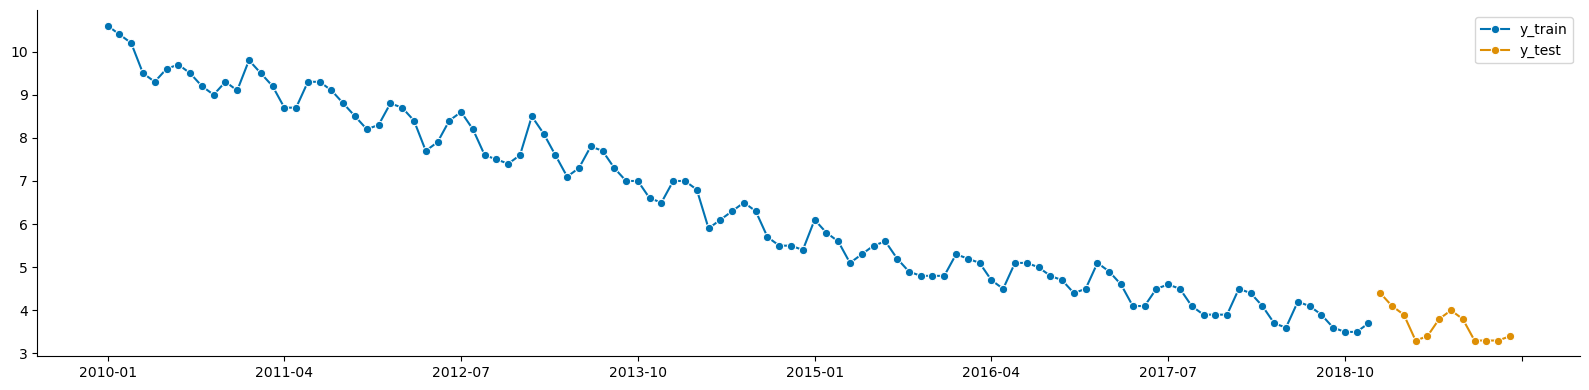

In [70]:
y_train, y_test = temporal_train_test_split(y, test_size=12)

plot_series(
    y_train, y_test, labels=['y_train', 'y_test']
)
plt.tight_layout()
sns.despine()

### 3. Set the forecast horizon to 12 months.

In [71]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12'],
            dtype='period[M]', is_relative=False)

### 4. Instantiate the reduced regression model, fit it to the data, and create predictions.

In [72]:
regressor = RandomForestRegressor(random_state=42)
rf_forecaster = make_reduction(
    estimator=regressor,
    strategy='recursive',
    window_length=12
)
rf_forecaster.fit(y_train)
y_pred_1 = rf_forecaster.predict(fh)

### 5. Evaluate the performance of the forecasts.

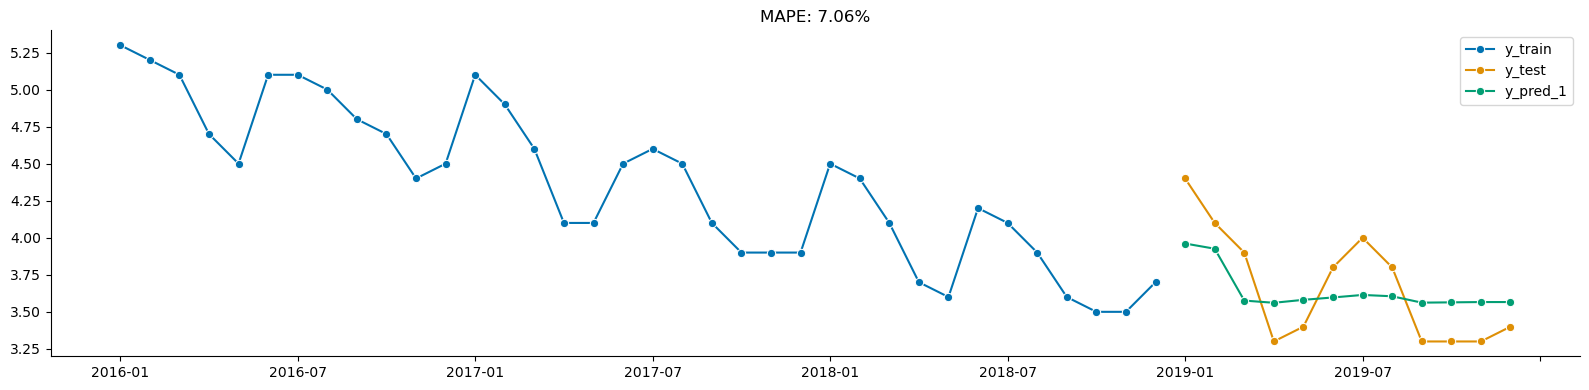

In [74]:
mape_1 = mean_absolute_percentage_error(
    y_test, y_pred_1,
    symmetric=False
)
fig, ax = plot_series(
    y_train["2016":], y_test, y_pred_1,
    labels=['y_train', 'y_test', 'y_pred_1']
)
ax.set_title(f"MAPE: {100*mape_1:.2f}%")

plt.tight_layout()
sns.despine()

### 6. Deseasonalize the time series.

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

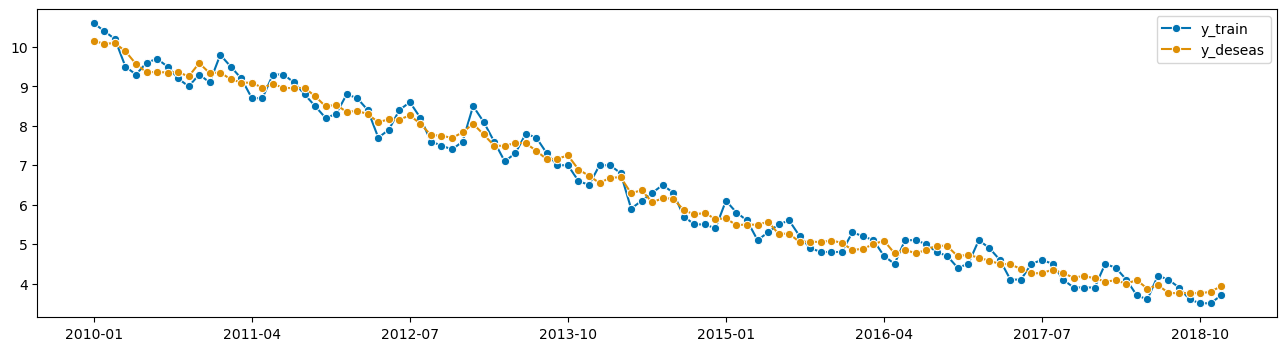

In [76]:
deseasonlizer = Deseasonalizer(model='additive', sp=12)
y_deseas = deseasonlizer.fit_transform(y_train)
plot_series(
    y_train, y_deseas,
    labels = ['y_train', 'y_deseas']
)

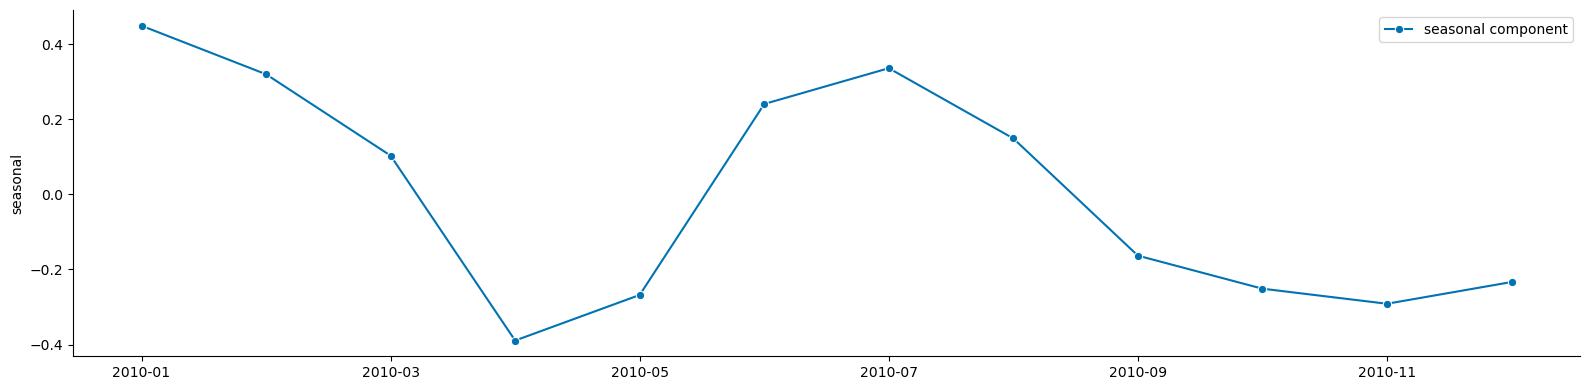

In [77]:
plot_series(
    deseasonlizer.seasonal_,
    labels=['seasonal component']
)

plt.tight_layout()
sns.despine()

### 7. Detrend the time series.

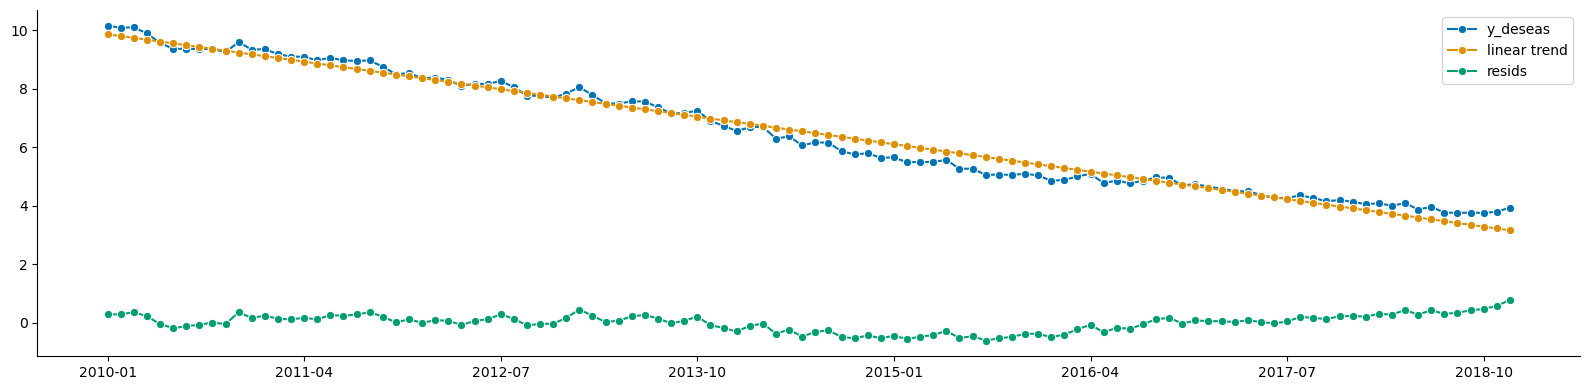

In [80]:
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
y_detrend = transformer.fit_transform(y_deseas)

# in-sample prediction
forecaster = PolynomialTrendForecaster(degree=1)
y_in_sample = (
    forecaster
    .fit(y_deseas)
    .predict(fh=-np.arange(len(y_deseas)))
)

plot_series(
    y_deseas, y_in_sample, y_detrend,
    labels=['y_deseas', 'linear trend', 'resids']
)

plt.tight_layout()
sns.despine()

### 8. Combine the components into a pipeline, fit it to the original time series, and obtain predictions.

In [81]:
rf_pipe = TransformedTargetForecaster(
    steps = [
        ("deseasonalize", Deseasonalizer(model='additive', sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", rf_forecaster)
    ]
)

rf_pipe.fit(y_train)
y_pred_2 = rf_pipe.predict(fh)

### 9. Evaluate the pipeline's predictions.

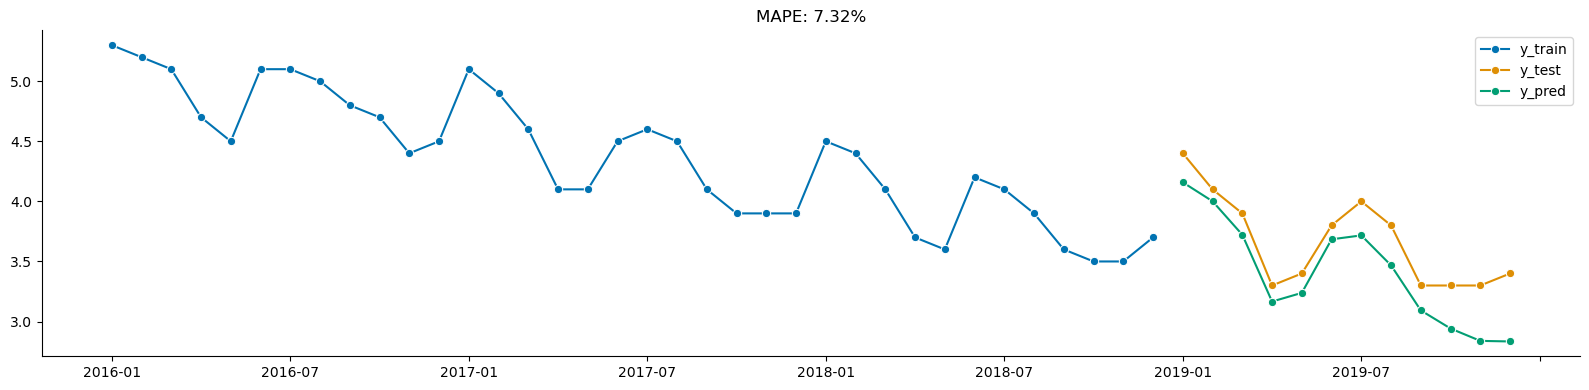

In [82]:
mape_2 = mean_absolute_percentage_error(
    y_test, y_pred_2, symmetric=False
)

fig, ax = plot_series(
    y_train["2016":], y_test, y_pred_2,
    labels=['y_train', 'y_test', 'y_pred']
)
ax.set_title(f"MAPE: {100*mape_2:.2f}%")

plt.tight_layout()
sns.despine()

### 10. Evaluate the performance using expanding window cross-validation.

In [83]:
cv = ExpandingWindowSplitter(
    fh=list(range(1, 13)),
    initial_window=12 * 5,
    step_length=12
)

cv_df = evaluate(
    forecaster=rf_pipe,
    y=y,
    cv=cv,
    strategy='refit',
    return_data=True
)

cv_df

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.017968,0.078636,0.031326,60,2014-12,unemp_rate Date 2010-0...,unemp_rate Date 2015-0...,unemp_rate 2015-01 6.189424 2015-0...
1,0.072160,0.056279,0.026446,72,2015-12,unemp_rate Date 2010-0...,unemp_rate Date 2016-0...,unemp_rate 2016-01 5.424690 2016-0...
2,0.092562,0.059037,0.026653,84,2016-12,unemp_rate Date 2010-0...,unemp_rate Date 2017-0...,unemp_rate 2017-01 5.043032 2017-0...
3,0.099018,0.060493,0.025478,96,2017-12,unemp_rate Date 2010-0...,unemp_rate Date 2018-0...,unemp_rate 2018-01 4.378566 2018-0...
4,0.073229,0.063009,0.027454,108,2018-12,unemp_rate Date 2010-0...,unemp_rate Date 2019-0...,unemp_rate 2019-01 4.158468 2019-0...


In [85]:
for ind, row in cv_df.iterrows():
    print(f"Fold {ind} ----")
    print(f"Training: {row['y_train'].index.min()} - {row['y_train'].index.max()}")
    print(f"Testing: {row['y_test'].index.min()} - {row['y_test'].index.max()}")

Fold 0 ----
Training: 2010-01 - 2014-12
Testing: 2015-01 - 2015-12
Fold 1 ----
Training: 2010-01 - 2015-12
Testing: 2016-01 - 2016-12
Fold 2 ----
Training: 2010-01 - 2016-12
Testing: 2017-01 - 2017-12
Fold 3 ----
Training: 2010-01 - 2017-12
Testing: 2018-01 - 2018-12
Fold 4 ----
Training: 2010-01 - 2018-12
Testing: 2019-01 - 2019-12


### 11. Plot the predictions from the cross-validation folds.

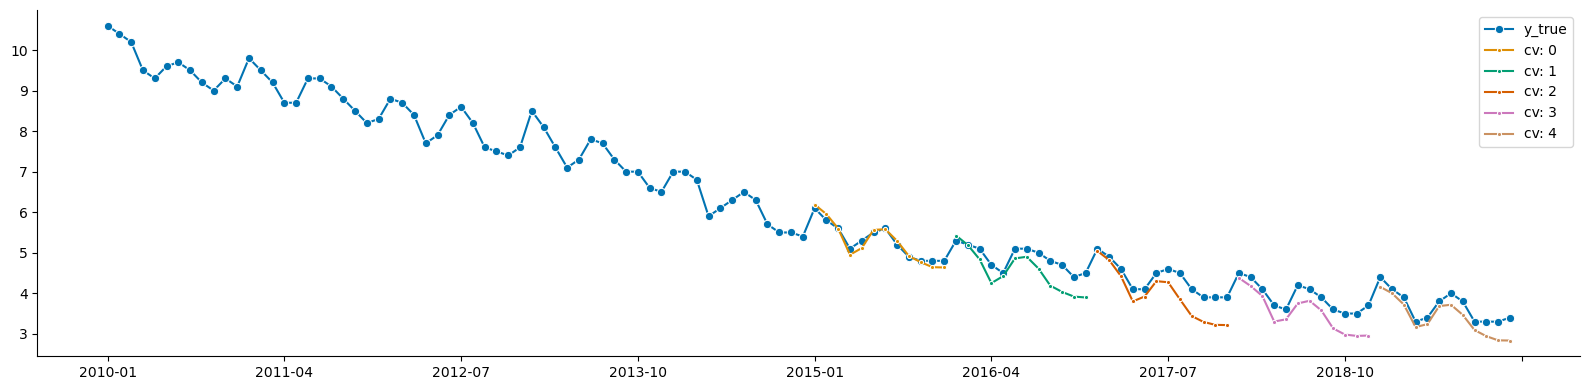

In [86]:
n_fold = len(cv_df)

plot_series(
    y,
    *[cv_df['y_pred'].iloc[x] for x in range(n_fold)],
    markers=['o', *['.'] * n_fold],
    labels=['y_true'] + [f'cv: {x}' for x in range(n_fold)]
)

plt.tight_layout()
sns.despine()

### 12. Create an ensemble forecast using the RF pipeline and AutoARIMA.

In [88]:
ensemble = EnsembleForecaster(
    forecasters=[
        ('autoarima', AutoARIMA(sp=12)),
        ('rf_pipe', rf_pipe)
    ]
)

ensemble.fit(y_train)
y_pred_3 = ensemble.predict(fh)

/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal movi

### 13. Evaluate the ensemble’s predictions

Text(0.5, 1.0, 'MAPE: 6.44%')

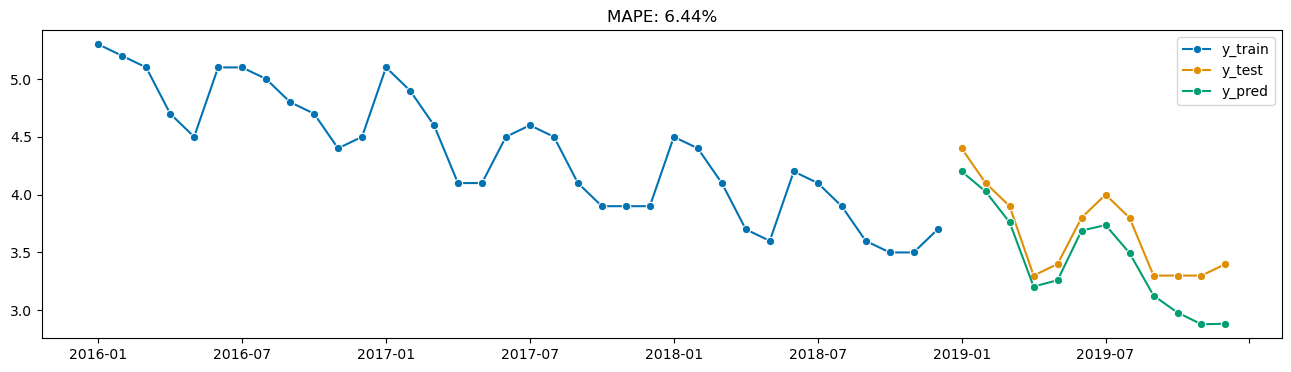

In [89]:
mape_3 = mean_absolute_percentage_error(
    y_test, y_pred_3, symmetric=False
)

fig, ax = plot_series(
    y_train["2016":], y_test, y_pred_3,
    labels=['y_train', 'y_test', 'y_pred']
)

ax.set_title(f"MAPE: {100*mape_3:.2f}%")

## There' more

### 1. Create naive forecast using the `NaiveForecaster`.

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

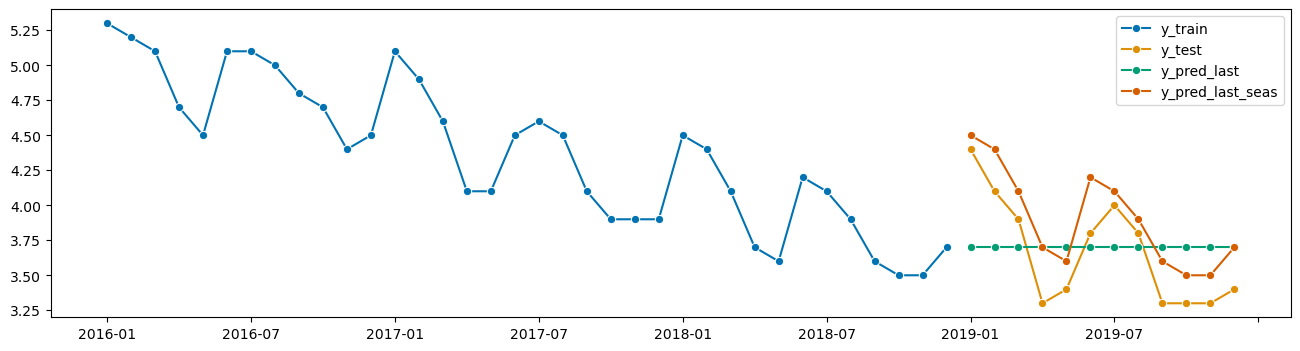

In [90]:
from sktime.forecasting.naive import NaiveForecaster

fh = ForecastingHorizon(y_test.index, is_relative=False)

naive_fcst_last = NaiveForecaster(strategy="last")
naive_fcst_last.fit(y_train)
y_last = naive_fcst_last.predict(fh)

naive_fcst_seas = NaiveForecaster(strategy="last", sp=12)
naive_fcst_seas.fit(y_train)
y_seasonal_last = naive_fcst_seas.predict(fh)

plot_series(
    y_train["2016":], y_test, y_last, y_seasonal_last,
    labels=['y_train', 'y_test', 'y_pred_last', 'y_pred_last_seas']
)

### 2. Inspect all the available models.

In [91]:
from sktime.registry import all_estimators

all_estimators("forecaster", as_dataframe=True)

,name,object
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
5,BATS,<class 'sktime.forecasting.bats.BATS'>
6,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
7,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
8,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
9,Croston,<class 'sktime.forecasting.croston.Croston'>


# Forecasting with Meta's Prophet

## How to do it

### 1. Import the libraries and authenticate with Nasdaq Data Link.

In [93]:
import pandas as pd
import numpy as np
import nasdaqdatalink
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

nasdaqdatalink.ApiConfig.api_key = 'hbwVh8xyxkjEKo8D1P8c'

### 2. Download the daily gold prices.

<Axes: title={'center': 'Daily gold prices (2015-2019)'}, xlabel='Date'>

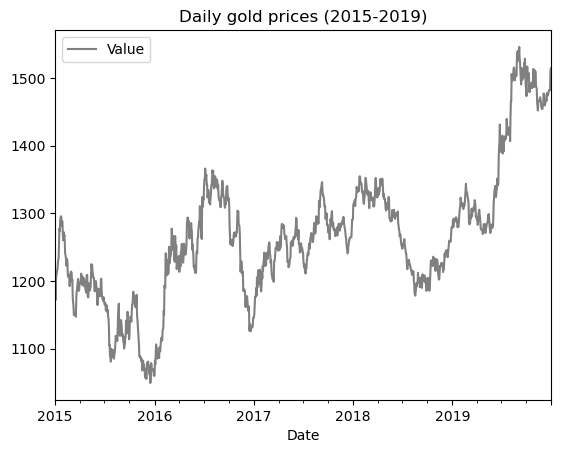

In [94]:
df = nasdaqdatalink.get(
    dataset='WGC/GOLD_DAILY_USD',
    start_date='2015-01-01',
    end_date='2019-12-31'
)
df.plot(title='Daily gold prices (2015-2019)')

### 3. Rename the columns.

In [95]:
df = df.reset_index(drop=False)
df.columns = ['ds', 'y']

### 4. Split the series into the training and test sets.

In [96]:
train_indices = df['ds'] < '2019-10-01'
df_train = df.loc[train_indices].dropna()
df_test = (
    df
    .loc[~train_indices]
    .reset_index(drop=True)
)

### 5. Create the instance of the model and fit it to the data.

In [97]:
prophet = Prophet(changepoint_range=0.9)
prophet.add_country_holidays(country_name='US')
prophet.add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=5
)
prophet.fit(df_train)

00:42:23 - cmdstanpy - INFO - Chain [1] start processing
00:42:24 - cmdstanpy - INFO - Chain [1] done processing


### 6. Forecast the gold prices for the fourth quarter of 2019 and plot the results.

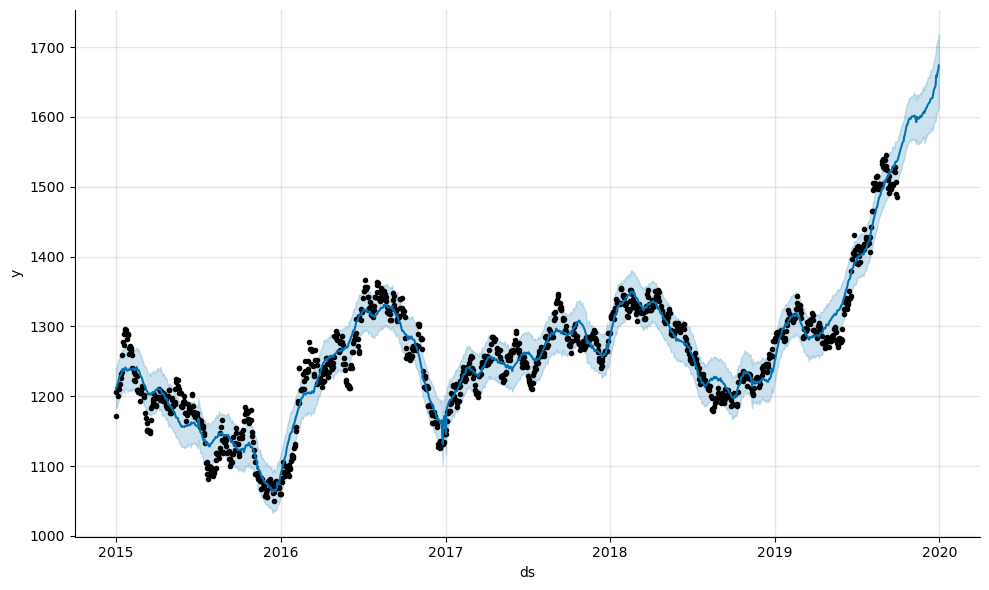

In [98]:
df_future = prophet.make_future_dataframe(
    periods=len(df_test), freq='B'
)
df_pred = prophet.predict(df_future)
prophet.plot(df_pred)

plt.tight_layout()
sns.despine()

In [100]:
df_pred.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       'Thanksgiv

### 7. Add changepoints to the plot.

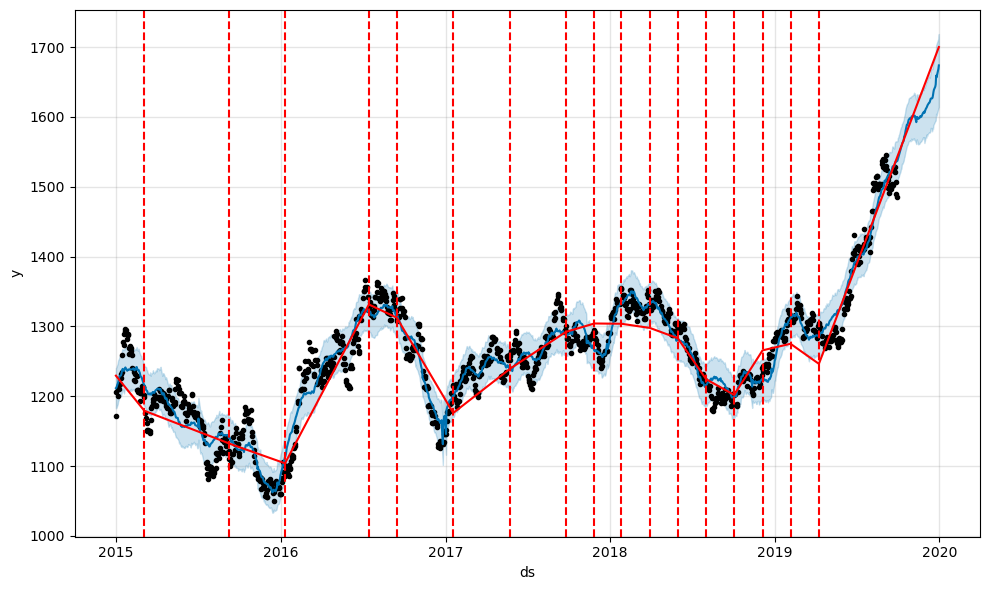

In [101]:
fig = prophet.plot(df_pred)
a = add_changepoints_to_plot(fig.gca(), prophet, df_pred)

### 8. Inspect the decomposition of the time series.

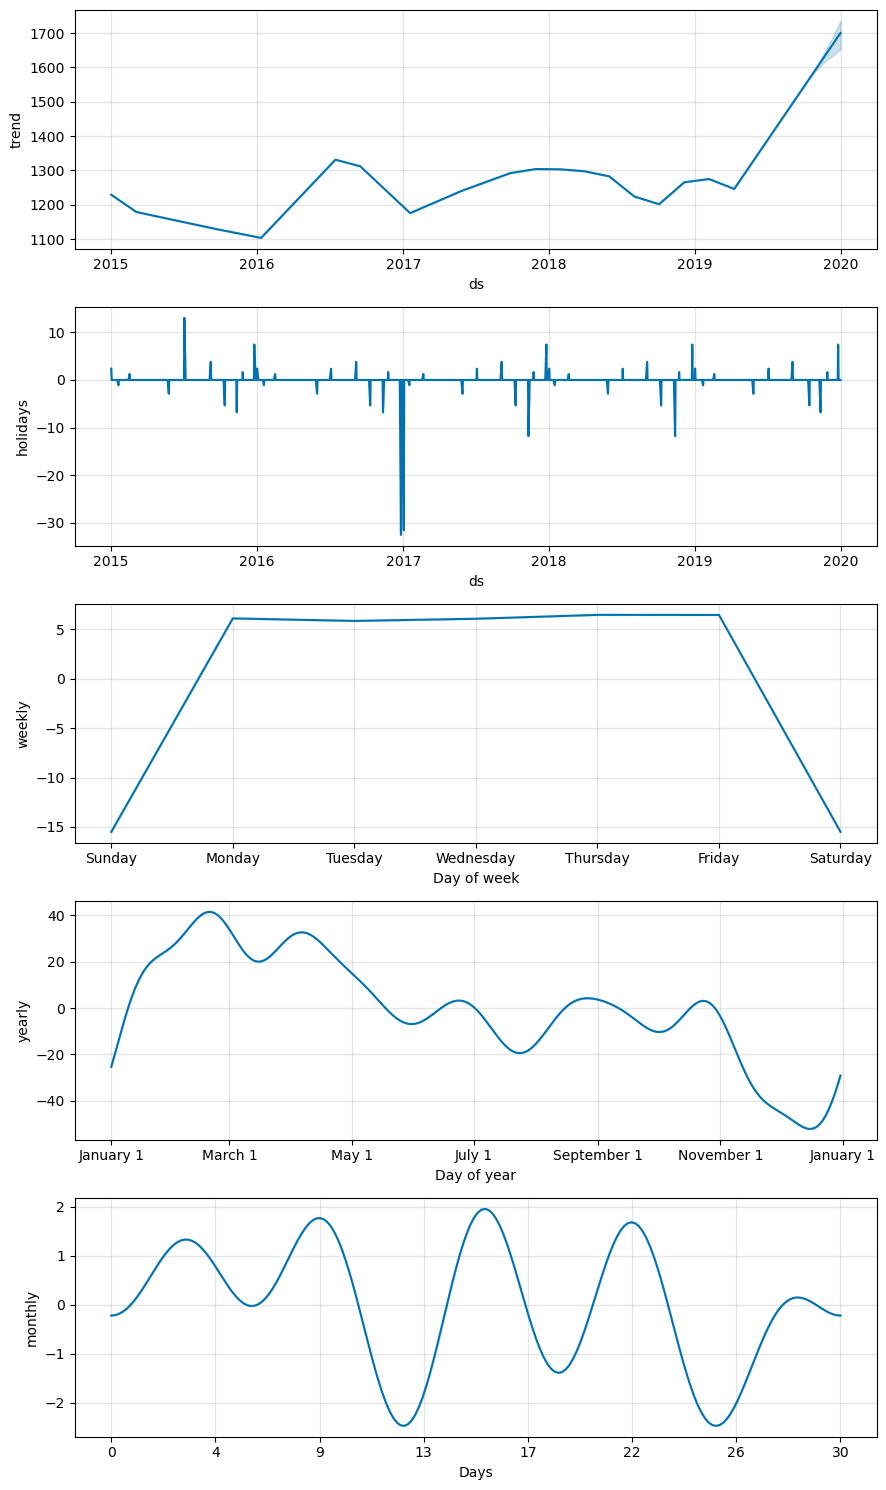

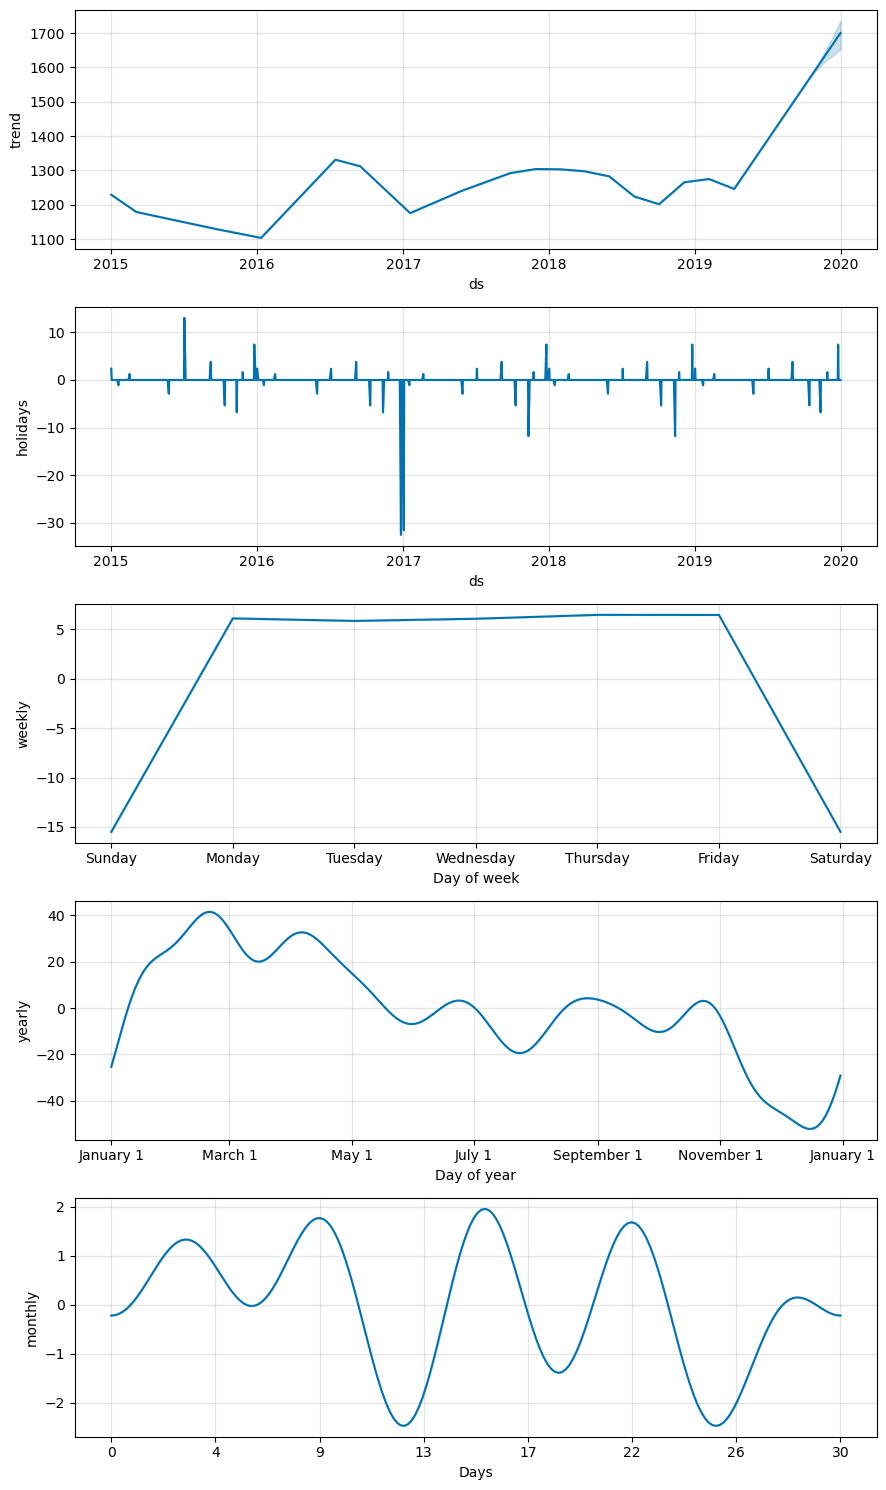

In [102]:
prophet.plot_components(df_pred)

### 9. Merge the test set with the forecasts.

In [103]:
SELECTED_COLS = [
    'ds', 'yhat', 'yhat_lower', 'yhat_upper'
]

df_pred = (
    df_pred
    .loc[:, SELECTED_COLS]
    .reset_index(drop=True)
)

df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test['ds'] = pd.to_datetime(df_test['ds'])
df_test = df_test.set_index('ds')

### 10. Plot the test values vs. predictions.

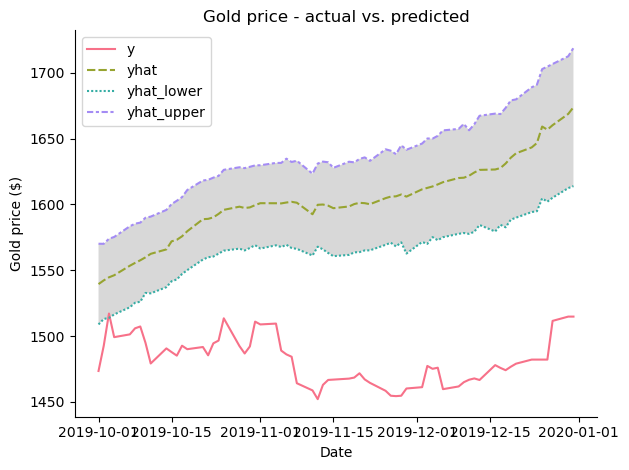

In [104]:
fig, ax = plt.subplots(1, 1)

PLOT_COLS = [
    'y', 'yhat', 'yhat_lower', 'yhat_upper'
]

ax = sns.lineplot(data=df_test[PLOT_COLS])
ax.fill_between(
    df_test.index,
    df_test['yhat_lower'],
    df_test['yhat_upper'],
    alpha=0.3
)

ax.set(
    title="Gold price - actual vs. predicted",
    xlabel="Date",
    ylabel="Gold price ($)"
)

plt.tight_layout()
sns.despine()

## There's more

### 1. Import the libraries

In [105]:
from prophet.diagnostics import (cross_validation, performance_metrics)
from prophet.plot import plot_cross_validation_metric

### 2. Run Prophet’s cross-validation

In [106]:
df_cv = cross_validation(
    prophet,
    initial='756 days',
    period='60 days',
    horizon='60 days'
)

df_cv

  0%|          | 0/16 [00:00<?, ?it/s]

01:20:43 - cmdstanpy - INFO - Chain [1] start processing
01:20:43 - cmdstanpy - INFO - Chain [1] done processing
01:20:43 - cmdstanpy - INFO - Chain [1] start processing
01:20:44 - cmdstanpy - INFO - Chain [1] done processing
01:20:44 - cmdstanpy - INFO - Chain [1] start processing
01:20:44 - cmdstanpy - INFO - Chain [1] done processing
01:20:44 - cmdstanpy - INFO - Chain [1] start processing
01:20:44 - cmdstanpy - INFO - Chain [1] done processing
01:20:44 - cmdstanpy - INFO - Chain [1] start processing
01:20:44 - cmdstanpy - INFO - Chain [1] done processing
01:20:44 - cmdstanpy - INFO - Chain [1] start processing
01:20:44 - cmdstanpy - INFO - Chain [1] done processing
01:20:44 - cmdstanpy - INFO - Chain [1] start processing
01:20:45 - cmdstanpy - INFO - Chain [1] done processing
01:20:45 - cmdstanpy - INFO - Chain [1] start processing
01:20:45 - cmdstanpy - INFO - Chain [1] done processing
01:20:45 - cmdstanpy - INFO - Chain [1] start processing
01:20:45 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-13,1239.144429,1212.176990,1264.421828,1222.25,2017-02-12
1,2017-02-14,1242.820073,1216.711483,1269.527433,1230.75,2017-02-12
2,2017-02-15,1244.573948,1217.570265,1273.760258,1224.40,2017-02-12
3,2017-02-16,1245.753184,1220.687185,1273.184292,1240.55,2017-02-12
4,2017-02-17,1245.458501,1217.466180,1272.059684,1241.95,2017-02-12
...,...,...,...,...,...,...
681,2019-09-24,1415.871174,1380.654037,1454.104774,1520.65,2019-08-01
682,2019-09-25,1416.019017,1383.321817,1449.840255,1528.75,2019-08-01
683,2019-09-26,1415.547885,1380.544929,1448.907238,1506.40,2019-08-01
684,2019-09-27,1413.859057,1377.241718,1449.590236,1489.90,2019-08-01


In [107]:
df_cv['cutoff'].value_counts().sort_index()

2017-02-12    44
2017-04-13    42
2017-06-12    44
2017-08-11    42
2017-10-10    43
2017-12-09    43
2018-02-07    42
2018-04-08    44
2018-06-07    42
2018-08-06    44
2018-10-05    42
2018-12-04    43
2019-02-02    43
2019-04-03    42
2019-06-02    44
2019-08-01    42
Name: cutoff, dtype: int64

In [108]:
df_cv.head(50)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-13,1239.144429,1212.176990,1264.421828,1222.25,2017-02-12
1,2017-02-14,1242.820073,1216.711483,1269.527433,1230.75,2017-02-12
2,2017-02-15,1244.573948,1217.570265,1273.760258,1224.40,2017-02-12
3,2017-02-16,1245.753184,1220.687185,1273.184292,1240.55,2017-02-12
4,2017-02-17,1245.458501,1217.466180,1272.059684,1241.95,2017-02-12
5,2017-02-20,1248.289637,1221.557465,1275.711609,1237.30,2017-02-12
6,2017-02-21,1250.860983,1224.498011,1278.927491,1233.20,2017-02-12
7,2017-02-22,1250.247913,1222.987310,1277.973650,1236.65,2017-02-12
8,2017-02-23,1249.961455,1222.188232,1277.673552,1247.90,2017-02-12
9,2017-02-24,1249.073998,1222.117788,1277.539063,1253.65,2017-02-12


### 3. Calculate the aggregated performance metrics.

In [109]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,6 days,1719.906735,41.471758,31.189329,0.023789,0.016920,0.023950,0.551471
1,7 days,1958.845434,44.258846,33.614691,0.025615,0.020005,0.025838,0.529412
2,8 days,2162.194532,46.499404,35.431029,0.026861,0.022921,0.027142,0.490642
3,9 days,2328.049829,48.249869,38.111460,0.028958,0.024270,0.029183,0.444853
4,10 days,2500.968316,50.009682,40.857015,0.031319,0.031076,0.031553,0.382353
5,11 days,2664.889970,51.622572,42.087049,0.032309,0.031076,0.032600,0.367647
6,12 days,2697.480881,51.937278,42.850797,0.032868,0.031154,0.033142,0.362299
7,13 days,2911.265954,53.956148,44.742838,0.034285,0.033456,0.034551,0.333333
8,14 days,3244.577938,56.961197,47.946933,0.036821,0.035280,0.037081,0.294118
9,15 days,3621.922178,60.182408,50.230453,0.038341,0.036060,0.038650,0.288770


### 4. Plot the MAPE score.

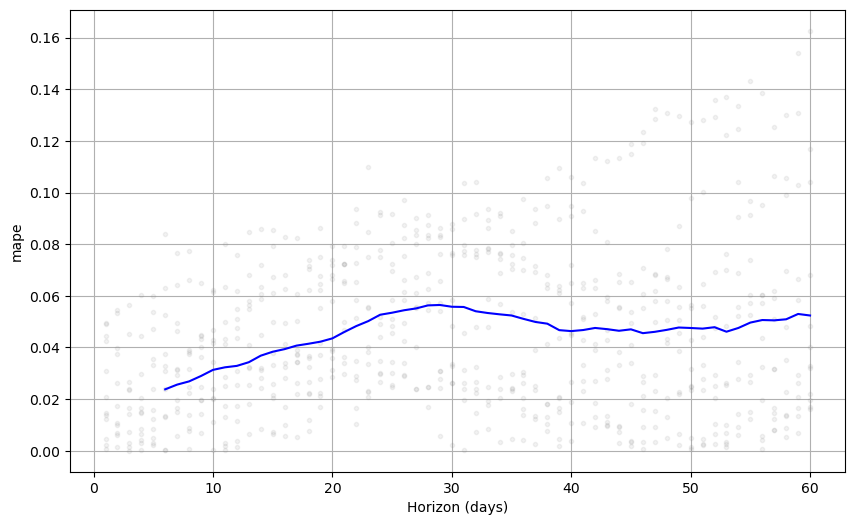

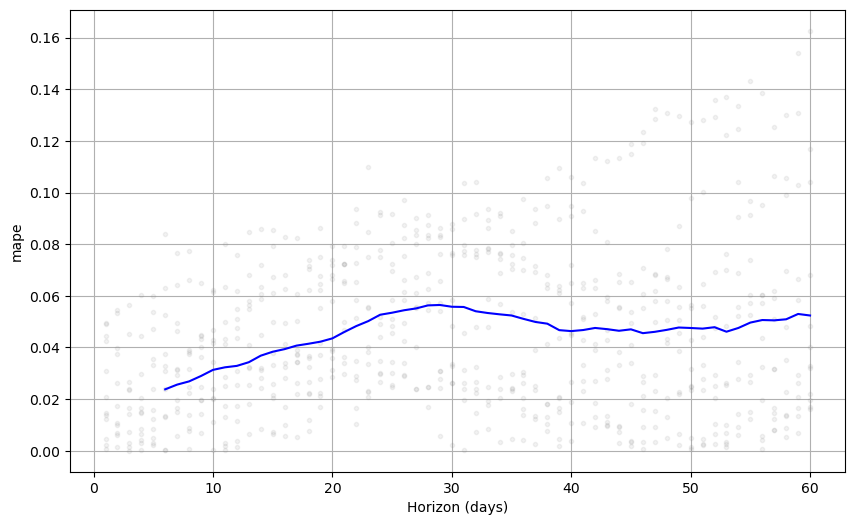

In [110]:
plot_cross_validation_metric(df_cv, metric='mape')

## Getting ready

### 1. Import the libraries and authenticate.

In [1]:
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = 'hbwVh8xyxkjEKo8D1P8c'

# AutoML for time series forecasting with PyCaret

### 2. Download the monthly US unemployment rate from years 2010-2019.

<Axes: title={'center': 'Unemployment rate (US) - monthly'}, xlabel='Date'>

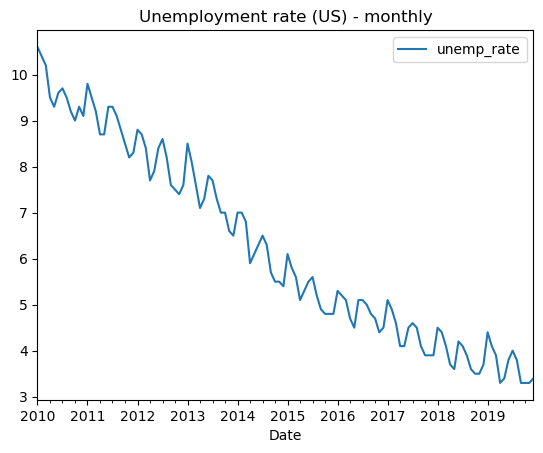

In [3]:
df = (
    nasdaqdatalink.get(dataset='FRED/UNRATENSA',
                       start_date='2010-01-01',
                       end_date='2019-12-31')
    .rename(columns={'Value': 'unemp_rate'})
)
df.plot(title="Unemployment rate (US) - monthly")

## How to do it

### 1. Import the libraries

In [6]:
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

### 2. Set up the experiment

In [7]:
exp = TSForecastingExperiment()
exp.setup(df, fh=6, fold=5, session_id=42)

,Description,Value
0,session_id,42
1,Target,unemp_rate
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(120, 1)"
5,Transformed data shape,"(120, 1)"
6,Transformed train set shape,"(114, 1)"
7,Transformed test set shape,"(6, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


### 3. Explore the time series using visualizations

In [9]:
exp.plot_model(
    plot='diagnostics',
    fig_kwargs={'height': 800, 'width': 1000}
)

In [11]:
exp.plot_model(plot='cv')

In [12]:
exp.plot_model(plot='ts')

In [13]:
exp.plot_model(plot='acf')

In [14]:
exp.plot_model(plot='decomp_stl')

In [15]:
exp.plot_model(plot='periodogram')

In [16]:
exp.plot_model(plot='fft')

### 4. Run statistical tests on the time series.

In [17]:
exp.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,120.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,6.225
3,Summary,Statistics,Transformed,Median,,5.6
4,Summary,Statistics,Transformed,Standard Deviation,,2.10223
5,Summary,Statistics,Transformed,Variance,,4.41937
6,Summary,Statistics,Transformed,Kurtosis,,-1.232708
7,Summary,Statistics,Transformed,Skewness,,0.345242
8,Summary,Statistics,Transformed,# Distinct Values,,59.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",1610.583379


In [18]:
exp.check_stats(test='summary')

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,120.000000
1,Summary,Statistics,Transformed,# Missing Values,,0.000000
2,Summary,Statistics,Transformed,Mean,,6.225000
3,Summary,Statistics,Transformed,Median,,5.600000
4,Summary,Statistics,Transformed,Standard Deviation,,2.102230
5,Summary,Statistics,Transformed,Variance,,4.419370
6,Summary,Statistics,Transformed,Kurtosis,,-1.232708
7,Summary,Statistics,Transformed,Skewness,,0.345242
8,Summary,Statistics,Transformed,# Distinct Values,,59.000000


### 5. Find the five best fitting pipelines.

In [20]:
best_pipelines = exp.compare_models(
    sort='MAPE', turbo=False, n_select=5
)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
bats,BATS,0.1222,0.1364,0.0911,0.1105,0.0225,0.0227,0.8702,2.0440
tbats,TBATS,0.1308,0.1410,0.0976,0.1142,0.0239,0.0242,0.8641,4.8120
auto_arima,Auto ARIMA,0.1487,0.1626,0.1111,0.1319,0.0280,0.0287,0.7229,2.6540
theta,Theta Forecaster,0.1802,0.1906,0.1348,0.1547,0.0332,0.0332,0.7221,0.0080
ets,ETS,0.1976,0.2108,0.1474,0.1708,0.0358,0.0364,0.6639,0.0180
stlf,STLF,0.1966,0.2022,0.1456,0.1627,0.0369,0.0379,0.6777,0.0120
exp_smooth,Exponential Smoothing,0.2074,0.2256,0.1547,0.1828,0.0371,0.0381,0.6565,0.0180
arima,ARIMA,0.2453,0.2573,0.1833,0.2088,0.0462,0.0477,0.4979,0.0180
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.2516,0.2635,0.1907,0.2163,0.0465,0.0481,0.4679,0.0460
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.2524,0.2662,0.1914,0.2185,0.0466,0.0482,0.4544,0.0300


In [21]:
best_pipelines

[BATS(show_warnings=False, sp=12, use_box_cox=True),
 TBATS(show_warnings=False, sp=[12], use_box_cox=True),
 AutoARIMA(random_state=42, sp=12, suppress_warnings=True),
 ThetaForecaster(sp=12),
 AutoETS(seasonal='mul', sp=12, trend='add')]

In [22]:
# recover the DataFrame with the metrics
compare_metrics_base = exp.pull()
compare_metrics_base

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
bats,BATS,0.1222,0.1364,0.0911,0.1105,0.0225,0.0227,0.8702,2.044
tbats,TBATS,0.1308,0.141,0.0976,0.1142,0.0239,0.0242,0.8641,4.812
auto_arima,Auto ARIMA,0.1487,0.1626,0.1111,0.1319,0.028,0.0287,0.7229,2.654
theta,Theta Forecaster,0.1802,0.1906,0.1348,0.1547,0.0332,0.0332,0.7221,0.008
ets,ETS,0.1976,0.2108,0.1474,0.1708,0.0358,0.0364,0.6639,0.018
stlf,STLF,0.1966,0.2022,0.1456,0.1627,0.0369,0.0379,0.6777,0.012
exp_smooth,Exponential Smoothing,0.2074,0.2256,0.1547,0.1828,0.0371,0.0381,0.6565,0.018
arima,ARIMA,0.2453,0.2573,0.1833,0.2088,0.0462,0.0477,0.4979,0.018
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.2516,0.2635,0.1907,0.2163,0.0465,0.0481,0.4679,0.046
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.2524,0.2662,0.1914,0.2185,0.0466,0.0482,0.4544,0.030


In [23]:
# inspect the available models
exp.models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
grand_means,Grand Means Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
polytrend,Polynomial Trend Forecaster,sktime.forecasting.trend.PolynomialTrendForeca...,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
exp_smooth,Exponential Smoothing,sktime.forecasting.exp_smoothing.ExponentialSm...,True
ets,ETS,sktime.forecasting.ets.AutoETS,True
theta,Theta Forecaster,sktime.forecasting.theta.ThetaForecaster,True


### 6. Tune the best pipelines

In [24]:
best_pipelines_tuned = [exp.tune_model(model) for model in best_pipelines]
best_pipelines_tuned

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-12,0.0945,0.1060,0.0748,0.0904,0.0174,0.0172,0.9412
1,2017-06,0.0870,0.0946,0.0665,0.0785,0.0159,0.0161,0.9283
2,2017-12,0.1445,0.1634,0.1087,0.1333,0.0262,0.0268,0.8405
3,2018-06,0.1043,0.1221,0.0765,0.0974,0.0207,0.0209,0.8028
4,2018-12,0.1805,0.1961,0.1290,0.1530,0.0321,0.0328,0.8382
Mean,NaT,0.1222,0.1364,0.0911,0.1105,0.0225,0.0227,0.8702
SD,NaT,0.0353,0.0379,0.0238,0.0280,0.0060,0.0062,0.0545


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.0s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-12,0.1086,0.1106,0.0860,0.0944,0.0195,0.0193,0.9360
1,2017-06,0.1106,0.1090,0.0845,0.0904,0.0202,0.0204,0.9048
2,2017-12,0.1368,0.1480,0.1029,0.1207,0.0245,0.0249,0.8692
3,2018-06,0.1032,0.1199,0.0757,0.0956,0.0206,0.0208,0.8098
4,2018-12,0.1947,0.2176,0.1391,0.1698,0.0346,0.0354,0.8008
Mean,NaT,0.1308,0.1410,0.0976,0.1142,0.0239,0.0242,0.8641
SD,NaT,0.0340,0.0407,0.0225,0.0298,0.0056,0.0059,0.0525


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-12,0.0288,0.0298,0.0228,0.0254,0.0050,0.0050,0.9954
1,2017-06,0.2671,0.2721,0.2041,0.2256,0.0503,0.0520,0.4068
2,2017-12,0.1487,0.1754,0.1119,0.1430,0.0276,0.0283,0.8163
3,2018-06,0.1597,0.1994,0.1171,0.1590,0.0314,0.0321,0.4737
4,2018-12,0.1390,0.1361,0.0993,0.1062,0.0259,0.0262,0.9220
Mean,NaT,0.1487,0.1626,0.1111,0.1319,0.0280,0.0287,0.7229
SD,NaT,0.0756,0.0798,0.0577,0.0658,0.0145,0.0150,0.2386


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   23.6s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.6min finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-12,0.1582,0.1652,0.1252,0.1409,0.0277,0.0276,0.8573
1,2017-06,0.1108,0.1230,0.0847,0.1020,0.0200,0.0201,0.8789
2,2017-12,0.2244,0.2304,0.1688,0.1879,0.0401,0.0410,0.6831
3,2018-06,0.2083,0.2136,0.1527,0.1704,0.0418,0.0407,0.3959
4,2018-12,0.1993,0.2206,0.1424,0.1722,0.0364,0.0368,0.7952
Mean,NaT,0.1802,0.1906,0.1348,0.1547,0.0332,0.0332,0.7221
SD,NaT,0.0410,0.0406,0.0288,0.0304,0.0082,0.0082,0.1767


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-12,0.1343,0.1434,0.1063,0.1223,0.0242,0.0238,0.8925
1,2017-06,0.0811,0.0893,0.0620,0.0741,0.0150,0.0151,0.9360
2,2017-12,0.0830,0.0873,0.0625,0.0712,0.0156,0.0158,0.9545
3,2018-06,0.1445,0.1521,0.1060,0.1213,0.0281,0.0281,0.6940
4,2018-12,0.0862,0.1028,0.0616,0.0803,0.0155,0.0157,0.9555
Mean,NaT,0.1058,0.1150,0.0797,0.0938,0.0197,0.0197,0.8865
SD,NaT,0.0276,0.0274,0.0216,0.0230,0.0054,0.0053,0.0989


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.8s finished


[BATS(show_warnings=False, sp=12, use_box_cox=True),
 TBATS(show_warnings=False, sp=[12], use_box_cox=True),
 AutoARIMA(random_state=42, sp=12, suppress_warnings=True),
 ThetaForecaster(sp=12),
 AutoETS(error='mul', seasonal='add', sp=12, trend='mul')]

### 7. Blend the five tuned pipelines.

In [25]:
blended_model = exp.blend_models(
    best_pipelines_tuned, method='mean'
)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-12,0.0954,0.0964,0.0755,0.0822,0.0172,0.0170,0.9514
1,2017-06,0.1097,0.1154,0.0838,0.0957,0.0201,0.0203,0.8934
2,2017-12,0.1396,0.1501,0.1050,0.1224,0.0253,0.0258,0.8655
3,2018-06,0.1247,0.1325,0.0915,0.1057,0.0245,0.0245,0.7676
4,2018-12,0.1447,0.1639,0.1034,0.1279,0.0257,0.0261,0.8870
Mean,NaT,0.1228,0.1317,0.0918,0.1068,0.0226,0.0228,0.8730
SD,NaT,0.0184,0.0240,0.0113,0.0168,0.0034,0.0035,0.0599


### 8. Create the predictions using the blended model and plot the forecasts.

In [26]:
y_pred = exp.predict_model(blended_model)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,EnsembleForecaster,0.1465,0.1463,0.1009,0.1112,0.0282,0.0285,0.8415


In [27]:
exp.plot_model(estimator=blended_model)

### 9. Finalize the model

In [28]:
final_model = exp.finalize_model(blended_model)
exp.plot_model(final_model)

In [29]:
y_pred = exp.predict_model(final_model)
print(y_pred)

         y_pred
2020-01  3.8939
2020-02  3.7281
2020-03  3.5167
2020-04  3.0832
2020-05  3.1055
2020-06  3.4737
